In [14]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

In [139]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [140]:
%R require(ggplot2); 

In [15]:
df = pd.read_csv("../data/keggs-subjects-rf-scores.csv")


In [16]:
df.head()

,kegg,over.abundant.health.conf,LS001,LS002,LS003,LS004,LS005,LS006,LS007,CD.SRS301865,...,HE.SRS016335,HE.SRS016495,HE.SRS017103,HE.SRS017433,HE.SRS018427,HE.SRS018656,HE.SRS020328,HE.SRS020869,HE.SRS022713,HE.SRS016585.suspect
0,K00001(alcohol_dehydrogenase),0.366,0.005732,0.006140,0.006243,0.005962,0.008011,0.004744,0.005444,0.005043,...,0.002705,0.005025,0.003359,0.004281,0.003052,0.003625,0.002673,0.003999,0.003734,8.220359e-03
1,K00002(alcohol_dehydrogenase_(NADP+)),0.312,0.000382,0.000409,0.000610,0.000533,0.000313,0.000412,0.000390,0.001005,...,0.000461,0.000255,0.000071,0.000014,0.000248,0.000649,0.000151,0.000157,0.000000,4.812945e-07
2,K00003(homoserine_dehydrogenase),0.310,0.000855,0.001034,0.001125,0.001074,0.001224,0.000721,0.000786,0.001025,...,0.000195,0.001063,0.000249,0.000131,0.000351,0.000676,0.000430,0.000318,0.000050,1.209999e-06
3,"K00004((R,R)-butanediol_dehydrogenase_/_diacet...",0.192,0.000091,0.000106,0.000149,0.000116,0.000064,0.000084,0.000080,0.000016,...,0.000006,0.000025,0.000008,0.000008,0.000014,0.000039,0.000068,0.000010,0.000006,4.127393e-04
4,K00005(glycerol_dehydrogenase),0.004,0.000167,0.000236,0.000223,0.000203,0.000218,0.000144,0.000143,0.000166,...,0.000012,0.000427,0.000030,0.000004,0.000034,0.000036,0.000055,0.000065,0.000000,2.158647e-04


In [17]:
X = df.iloc[:,2:].values.T

In [18]:
X.shape

(63, 10012)

In [19]:
from sklearn.manifold import TSNE

In [174]:
X_embedded = TSNE(n_components=2, perplexity=3, learning_rate = .1).fit_transform(np.log10(1e-9+X))

df_tsne = pd.DataFrame(X_embedded)
df_tsne.columns = ["tsne1", "tsne2"]
df_tsne["subject"] = list(df.columns[2:])

df_tsne["cohort"] = [subject[:2] for subject in list(df_tsne.subject)]

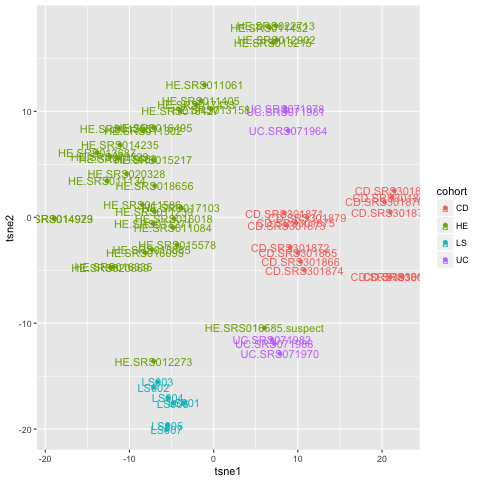

In [175]:
%%R -i df_tsne

ggplot(df_tsne, aes(x = tsne1, y = tsne2, label = subject, colour = cohort)) + geom_point() + geom_text()

In [176]:
from sklearn.tree import DecisionTreeClassifier

In [199]:
accuracies = []
for depth in range(1,21):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_embedded, df_tsne.cohort)
    accuracies.append(tree_clf.score(X_embedded, df_tsne.cohort))

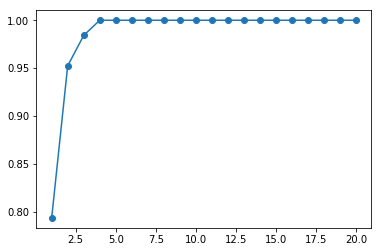

In [200]:
plt.plot(range(1,21), accuracies, '-o')

In [207]:
accuracies

[0.7936507936507936,
 0.9523809523809523,
 0.9841269841269841,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [208]:
def return_score(X_sample, tree_depth = 3, subject_names = list(df.columns[2:])):
    X_embedded = TSNE(n_components=2, perplexity=3, learning_rate = .1).fit_transform(np.log10(1e-9+X_sample))

    df_tsne = pd.DataFrame(X_embedded)
    df_tsne.columns = ["tsne1", "tsne2"]
    df_tsne["subject"] = subject_names

    df_tsne["cohort"] = [subject[:2] for subject in list(df_tsne.subject)]
    
    tree_clf = DecisionTreeClassifier(max_depth=tree_depth)
    tree_clf.fit(X_embedded, df_tsne.cohort)
    return tree_clf.score(X_embedded, df_tsne.cohort)



In [209]:
return_score(X[:,:1515])

0.9047619047619048

In [214]:
col_indx = np.random.choice(X.shape[1], 100, replace=False)

In [215]:
return_score(X[:,col_indx])

0.9047619047619048

In [266]:
%%time
accuracies = []
good_cols = []
for _ in range(1000):
    col_indx = np.random.choice(X.shape[1], 20, replace=False)
    accuracy = return_score(X[:,col_indx], tree_depth=2)
    accuracies.append(accuracy)
    if accuracy > .95:
        good_cols.append(col_indx)

CPU times: user 7min 22s, sys: 2min 11s, total: 9min 34s
Wall time: 9min 36s


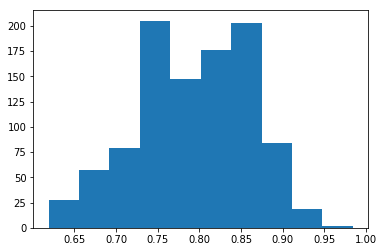

In [267]:
plt.hist(np.array(accuracies));

In [274]:
np.max(accuracies)

0.9841269841269841

In [268]:
len(set(list(np.array(good_cols).reshape(1,-1).squeeze())))

40

In [270]:
X[:, good_cols[0]];

In [271]:
import seaborn as sns

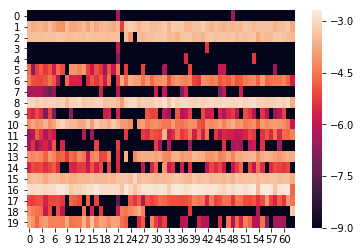

In [272]:
sns.heatmap(np.log10(1e-9+X[:, good_cols[0]]).T)

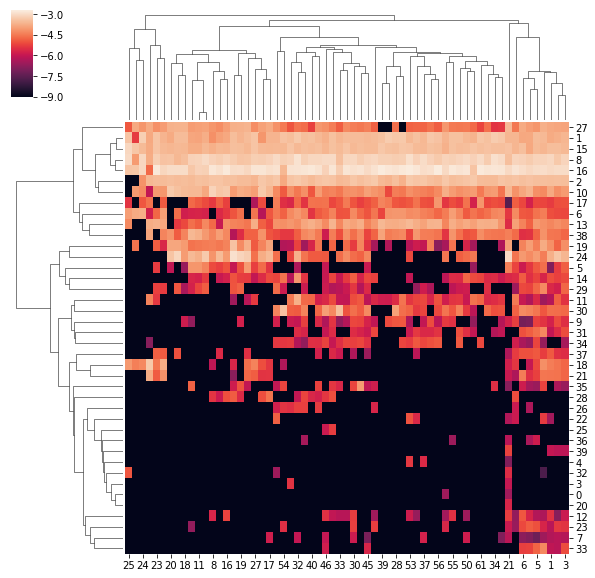

In [276]:
g = sns.clustermap(np.log10(1e-9+X[:, list(np.array(good_cols).reshape(1,-1).squeeze())]).T)

In [264]:
df_tsne.cohort

0     LS
1     LS
2     LS
3     LS
4     LS
5     LS
6     LS
7     CD
8     CD
9     CD
10    CD
11    CD
12    CD
13    CD
14    CD
15    CD
16    CD
17    CD
18    CD
19    CD
20    CD
21    CD
22    UC
23    UC
24    UC
25    UC
26    UC
27    UC
28    HE
29    HE
      ..
33    HE
34    HE
35    HE
36    HE
37    HE
38    HE
39    HE
40    HE
41    HE
42    HE
43    HE
44    HE
45    HE
46    HE
47    HE
48    HE
49    HE
50    HE
51    HE
52    HE
53    HE
54    HE
55    HE
56    HE
57    HE
58    HE
59    HE
60    HE
61    HE
62    HE
Name: cohort, Length: 63, dtype: object

In [278]:
X.shape

(63, 10012)

In [286]:
non_zero_lengths = []
for i in range(X.shape[0]):
    non_zero_lengths.append(len(np.where(X[i,:] > 0)[0]))

In [288]:
np.min(non_zero_lengths)

2775